In [28]:
import numpy as np

def load_frametimes(base_path, num_cameras=6):
    """
    Load frametimes.npy files for a specified number of cameras.

    Parameters:
    - base_path (str): The base path where the main folder is located.
    - num_cameras (int): The number of cameras to load frametimes for. Default is 6.

    Returns:
    - dict: A dictionary with camera names as keys and frametimes data as values.
    """
    frametimes = {}
    for i in range(1, num_cameras + 1):
        camera_path = f'{base_path}/videos/Camera{i}/frametimes.npy'
        try:
            frametimes[f'Camera{i}'] = np.load(camera_path)
            print(f"Loaded frametimes for Camera{i}")
        except FileNotFoundError:
            print(f"File not found: {camera_path}")
    return frametimes

def check_max_shapes_consistency(frametimes_data):
    max_shapes = {camera: data.shape[1] for camera, data in frametimes_data.items()}
    print("Maximum shapes for each camera:", max_shapes)
    
    # Get the set of unique shape values
    unique_shapes = set(max_shapes.values())
    
    # Check if all cameras have the same shape and find the maximum shape value
    consistency = len(unique_shapes) == 1
    max_shape_value = max(max_shapes.values())
    
    return consistency, max_shape_value


def create_standard_timeline(frametimes_data, max_shape_value, fps=30):
    # Extract the end times and frame numbers for each camera
    end_times = {camera: frametimes_data[camera][1][-1] for camera in frametimes_data.keys()}
    max_frame_numbers = {camera: frametimes_data[camera][0][-1] for camera in frametimes_data.keys()}
    
    # Determine the maximum end time and frame number across all cameras
    max_end_time = int(round(max(end_times.values())))
    max_frame_number = max(max_frame_numbers.values())
    if max_frame_number > max_shape_value:
        max_frame_number = max_shape_value

    print(f"max frame number {max_frame_number}")
    
    # Calculate the interval between frames
    frame_interval = 1 / fps
    
    # Generate standard timeline and frame numbers
    standard_timeline = np.arange(0, max_end_time, frame_interval)
    standard_frame_numbers = np.arange(1, max_frame_number+1)
    
    return standard_frame_numbers, standard_timeline, max_frame_number

# Modified align_to_standard_timeline to align both timestamps and frame numbers
def align_to_standard_timeline(frametimes_data, standard_frame_numbers, standard_timeline, max_frame_numbers):
    aligned_data = {}
    # print(max_frame_numbers)
    for camera, data in frametimes_data.items():
        frame_numbers, timestamps = data[0], data[1]
        print(data[0].shape[0])
        if data[0].shape[0] == max_frame_numbers:
            print(f"skipping {camera} since no frame is missing")
            continue
        aligned_frames = []
        aligned_timestamps = []
        last_frame_number = standard_frame_numbers[0]  # Start with the first frame number as the prior value
        j = 0

        for frame in standard_frame_numbers:
            # Check if we are within bounds of frame_numbers and if we have a match
            if j < len(frame_numbers) and frame_numbers[j] == frame:
                aligned_frames.append(frame_numbers[j])
                aligned_timestamps.append(timestamps[j])
                last_frame_number = frame_numbers[j]
                j += 1  # Move to the next frame in frame_numbers
            else:
                # Frame is missing, fill with the previous frame number and NaN timestamp
                aligned_frames.append(last_frame_number)
                aligned_timestamps.append(np.nan)
                # print(f"Missing frame detected, filling with previous frame number {last_frame_number}")


        aligned_data[camera] = {
            "frames": np.array(aligned_frames),
            "timestamps": np.array(aligned_timestamps)
        }
        print(f"Aligned data for {camera} with {np.isnan(aligned_timestamps).sum()} dropped frames filled.")
    
    return aligned_data

# Main function to process camera data
def process_camera_data(frametimes_data, fps=30):
    # Step 1: Check for consistency in frame shapes
    consistency, max_shape_value = check_max_shapes_consistency(frametimes_data)
    if consistency:
        # raise ValueError("Cameras have inconsistent shapes.")
        print("Cameras have consistent shapes. Skipping alignment.")
        return
    
    # Step 2: Create the standard timeline and frame numbers
    standard_frame_numbers, standard_timeline, max = create_standard_timeline(frametimes_data, max_shape_value)
    
    # Step 3: Align camera data to the standard timeline
    aligned_frametimes = align_to_standard_timeline(frametimes_data, standard_frame_numbers, standard_timeline, max_shape_value)
    
    print("All cameras aligned successfully.")
    return aligned_frametimes, standard_frame_numbers, standard_timeline

# # Example usage
# base_path = '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_08_29/20240717_PMCr2'
base_path = '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_04/20240916V1r2/'
frametimes_data = load_frametimes(base_path)
aligned_frametimes, standard_frame_numbers, standard_timeline = process_camera_data(frametimes_data, fps=30)


# Print aligned frame numbers
for camera, frames in aligned_frametimes.items():
    print(f"{camera} aligned frame numbers:", frames)

Loaded frametimes for Camera1
Loaded frametimes for Camera2
Loaded frametimes for Camera3
Loaded frametimes for Camera4
Loaded frametimes for Camera5
Loaded frametimes for Camera6
Maximum shapes for each camera: {'Camera1': 2535, 'Camera2': 2530, 'Camera3': 2530, 'Camera4': 2532, 'Camera5': 2567, 'Camera6': 2530}
max frame number 2567.0
2535
Aligned data for Camera1 with 32 dropped frames filled.
2530
Aligned data for Camera2 with 37 dropped frames filled.
2530
Aligned data for Camera3 with 37 dropped frames filled.
2532
Aligned data for Camera4 with 35 dropped frames filled.
2567
skipping Camera5 since no frame is missing
2530
Aligned data for Camera6 with 37 dropped frames filled.
All cameras aligned successfully.
Camera1 aligned frame numbers: {'frames': array([1.000e+00, 2.000e+00, 3.000e+00, ..., 2.535e+03, 2.535e+03,
       2.535e+03]), 'timestamps': array([0.        , 0.03335118, 0.06670246, ...,        nan,        nan,
              nan])}
Camera2 aligned frame numbers: {'frame

In [37]:
aligned_frametimes

{'Camera1': {'frames': array([1.000e+00, 2.000e+00, 3.000e+00, ..., 2.535e+03, 2.535e+03,
         2.535e+03]),
  'timestamps': array([0.        , 0.03335118, 0.06670246, ...,        nan,        nan,
                nan])},
 'Camera2': {'frames': array([1.00e+00, 2.00e+00, 3.00e+00, ..., 2.53e+03, 2.53e+03, 2.53e+03]),
  'timestamps': array([0.        , 0.03335886, 0.06669852, ...,        nan,        nan,
                nan])},
 'Camera3': {'frames': array([1.00e+00, 2.00e+00, 3.00e+00, ..., 2.53e+03, 2.53e+03, 2.53e+03]),
  'timestamps': array([0.        , 0.03335503, 0.06669854, ...,        nan,        nan,
                nan])},
 'Camera4': {'frames': array([1.000e+00, 2.000e+00, 3.000e+00, ..., 2.532e+03, 2.532e+03,
         2.532e+03]),
  'timestamps': array([0.        , 0.0333512 , 0.06670627, ...,        nan,        nan,
                nan])},
 'Camera6': {'frames': array([1.00e+00, 2.00e+00, 3.00e+00, ..., 2.53e+03, 2.53e+03, 2.53e+03]),
  'timestamps': array([0.        , 0.

In [38]:
def get_shapes(data):
    shapes = {}
    for camera, values in data.items():
        shapes[camera] = {
            'frames_shape': len(values['frames']),
            'timestamps_shape': len(values['timestamps'])
        }
    return shapes

# Get shapes for each camera
shapes = get_shapes(aligned_frametimes)

In [39]:
shapes

{'Camera1': {'frames_shape': 2567, 'timestamps_shape': 2567},
 'Camera2': {'frames_shape': 2567, 'timestamps_shape': 2567},
 'Camera3': {'frames_shape': 2567, 'timestamps_shape': 2567},
 'Camera4': {'frames_shape': 2567, 'timestamps_shape': 2567},
 'Camera6': {'frames_shape': 2567, 'timestamps_shape': 2567}}

In [29]:
aligned_frametimes['Camera3']['timestamps'][~np.isnan(aligned_frametimes['Camera3']['timestamps'])].shape

(2530,)

In [30]:
aligned_frametimes['Camera3']['timestamps'][:100]

array([0.        , 0.03335503, 0.06669854, 0.1000537 , 0.13340103,
       0.16675217, 0.20010343, 0.23345459, 0.26680574, 0.30015309,
       0.33350441, 0.36685556, 0.40020676, 0.43355417, 0.46690149,
       0.50025658, 0.53360767, 0.5669513 , 0.60030627, 0.63365747,
       0.66700869, 0.70035606, 0.73370723, 0.7670584 , 0.80040967,
       0.83375699, 0.86710825, 0.90045943, 0.93381061, 0.96715802,
       1.000513  , 1.03386037, 1.06721162, 1.10055894, 1.1339101 ,
       1.16726136, 1.2006126 , 1.23396378, 1.26730723, 1.30066619,
       1.3340135 , 1.3673647 , 1.40071209, 1.43406717, 1.46741454,
       1.50076181, 1.534113  , 1.56746427, 1.60081549, 1.63416663,
       1.66751399, 1.70086525, 1.73421639, 1.76756766, 1.80091501,
       1.83427013, 1.86761668, 1.90096866, 1.93431978, 1.96767801,
       2.00101843, 2.03436952, 2.06772078, 2.10107195, 2.13442323,
       2.16777436, 2.20111795, 2.23447683, 2.26782419, 2.30117539,
       2.33452266, 2.36787778, 2.40122131, 2.43457242, 2.46792

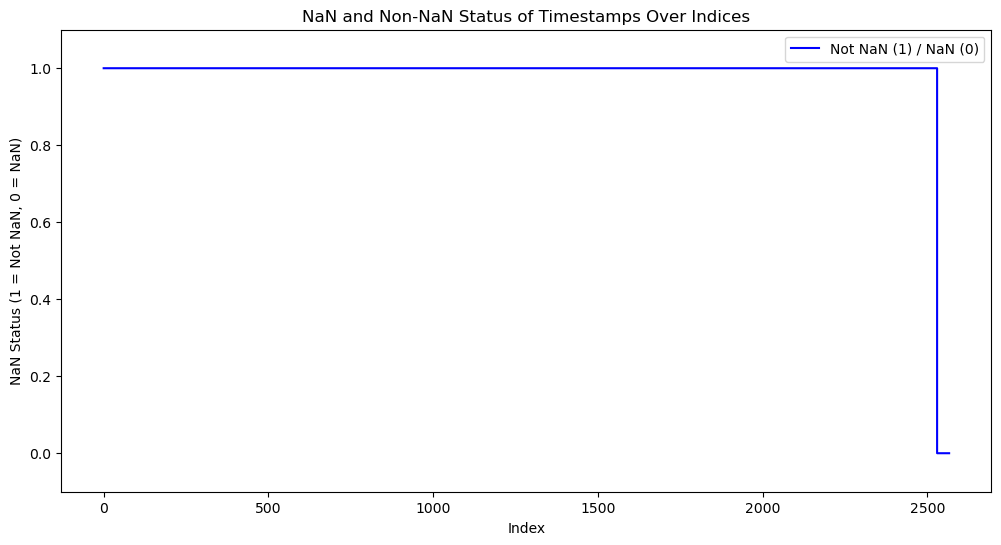

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Example data
timestamps = aligned_frametimes['Camera3']['timestamps']

# Generate indices for each timestamp
indices = np.arange(len(timestamps))

# Create a boolean array where 1 indicates a non-NaN value and 0 indicates a NaN value
nan_status = ~np.isnan(timestamps)  # True for non-NaN, False for NaN

# Plot the nan status
plt.figure(figsize=(12, 6))
plt.plot(indices, nan_status, color='blue', label='Not NaN (1) / NaN (0)', drawstyle='steps-mid')

# Labeling the plot
plt.xlabel("Index")
plt.ylabel("NaN Status (1 = Not NaN, 0 = NaN)")
plt.ylim(-0.1, 1.1)  # Adding a bit of space around y-axis
plt.title("NaN and Non-NaN Status of Timestamps Over Indices")
plt.legend()
plt.show()


In [41]:
import numpy as np

# Example aligned frames and timestamps for Camera3
aligned_frames = np.array([1.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00, 3.0000e+00, 4.0000e+00])
data_frame = np.array([3, 4, 5, 6, 7, 8])  # Example starting with 3

# Compute the offset
frame_start = data_frame[0]
offset = frame_start - 1

# Map aligned frames to the adjusted data_frame
mapped_frames = aligned_frames + offset

# Now you can update data_frame with mapped_frames
updated_data_frame = np.where(~np.isnan(mapped_frames), mapped_frames, data_frame)

print("Original data_frame:", data_frame)
print("Updated data_frame:", updated_data_frame)


Original data_frame: [3 4 5 6 7 8]
Updated data_frame: [3. 3. 4. 5. 5. 6.]


In [42]:
mapped_frames

array([3., 3., 4., 5., 5., 6.])

In [46]:
import sys
import os
sys.path.append(os.path.abspath('../..'))
from utlis.sync_utlis.sync_df_utlis import find_calib_file
import scipy.io as sio


def update_data_frame(base_path, aligned_frametimes):
    calib_path = find_calib_file(base_path)
    calib_data = sio.loadmat(calib_path)
    sync = calib_data['sync']
    cameras = [f'Camera{i}' for i in range(1, 7)]
    keyyyyy = 'data_frame'
    updated_frames = {}

    for cam_idx, camera in enumerate(cameras):
        # data_frame = sync[cam_idx][0][keyyyyy][0][0][0]
        # print(data_frame)
        if camera in aligned_frametimes:
            # import pdb
            # pdb.set_trace()

            data_frame = sync[cam_idx][0][keyyyyy][0][0][0]
            # print(data_frame.shape)
            print(data_frame)
            aligned_frames = aligned_frametimes[camera]['frames']

            # Compute the offset based on the starting value of data_frame
            frame_start = data_frame[0]
            offset = frame_start - 1

            # Map aligned frames to the adjusted data_frame
            mapped_frames = aligned_frames + offset
            # print(mapped_frames.shape, mapped_frames.shape, data_frame.shape)
            # Handle NaN values: Replace NaNs with original data_frame values
            # updated_data_frame = np.where(~np.isnan(mapped_frames), mapped_frames, data_frame)

            # Store the updated data_frame
            updated_frames[camera] = mapped_frames
            # sync[cam_idx][0][keyyyyy][0][0] = mapped_frames
        else:
            print(f"{camera} does not exist in aligned_frametimes")
        
        # calib_data['sync'] = sync
        # scipy.io.savemat(save_path, calib_data)
        # print('dropped_handled data saved to:', save_path)

    return updated_frames


updated_frames = update_data_frame(base_path, aligned_frametimes)

# Print updated frames for each camera if available
for cam, frames in updated_frames.items():
    print(f"Updated frames for {cam}: {frames}")

[   6.    7.    8. ... 2528. 2529. 2530.]
[1.000e+00 2.000e+00 3.000e+00 ... 2.528e+03 2.529e+03 2.530e+03]
[1.000e+00 2.000e+00 3.000e+00 ... 2.528e+03 2.529e+03 2.530e+03]
[   3.    4.    5. ... 2528. 2529. 2530.]
Camera5 does not exist in aligned_frametimes
[1.000e+00 2.000e+00 3.000e+00 ... 2.528e+03 2.529e+03 2.530e+03]
Updated frames for Camera1: [   6.    7.    8. ... 2540. 2540. 2540.]
Updated frames for Camera2: [1.00e+00 2.00e+00 3.00e+00 ... 2.53e+03 2.53e+03 2.53e+03]
Updated frames for Camera3: [1.00e+00 2.00e+00 3.00e+00 ... 2.53e+03 2.53e+03 2.53e+03]
Updated frames for Camera4: [   3.    4.    5. ... 2534. 2534. 2534.]
Updated frames for Camera6: [1.00e+00 2.00e+00 3.00e+00 ... 2.53e+03 2.53e+03 2.53e+03]


In [47]:
os.path.dirname(base_path)

'/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_04/20240916V1r2'

In [12]:
import numpy as np

def load_frametimes(base_path, num_cameras=6):
    """
    Load frametimes.npy files for a specified number of cameras.

    Parameters:
    - base_path (str): The base path where the main folder is located.
    - num_cameras (int): The number of cameras to load frametimes for. Default is 6.

    Returns:
    - dict: A dictionary with camera names as keys and frametimes data as values.
    """
    frametimes = {}
    for i in range(1, num_cameras + 1):
        camera_path = f'{base_path}/videos/Camera{i}/frametimes.npy'
        try:
            frametimes[f'Camera{i}'] = np.load(camera_path)
            print(f"Loaded frametimes for Camera{i}")
        except FileNotFoundError:
            print(f"File not found: {camera_path}")
    return frametimes

# Example usage
base_path = '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_08_29/20240717_PMCr2'
# base_path = '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_04/20240916V1r2/'
frametimes_data = load_frametimes(base_path)


Loaded frametimes for Camera1
Loaded frametimes for Camera2
Loaded frametimes for Camera3
Loaded frametimes for Camera4
Loaded frametimes for Camera5
Loaded frametimes for Camera6


In [13]:
frametimes_data

{'Camera1': array([[1.00000000e+00, 2.00000000e+00, 3.00000000e+00, ...,
         2.78980000e+04, 2.78990000e+04, 2.79000000e+04],
        [0.00000000e+00, 3.33506080e-02, 6.66986720e-02, ...,
         9.30371212e+02, 9.30404560e+02, 9.30437911e+02]]),
 'Camera2': array([[1.00000000e+00, 2.00000000e+00, 3.00000000e+00, ...,
         2.78980000e+04, 2.78990000e+04, 2.79000000e+04],
        [0.00000000e+00, 3.33473680e-02, 6.66985600e-02, ...,
         9.30369457e+02, 9.30402808e+02, 9.30436159e+02]]),
 'Camera3': array([[1.00000000e+00, 2.00000000e+00, 3.00000000e+00, ...,
         1.57460000e+04, 1.57470000e+04, 1.57480000e+04],
        [0.00000000e+00, 3.33434480e-02, 6.66946720e-02, ...,
         5.41338787e+02, 5.41538886e+02, 5.41705645e+02]]),
 'Camera4': array([[1.00000000e+00, 2.00000000e+00, 3.00000000e+00, ...,
         2.78980000e+04, 2.78990000e+04, 2.79000000e+04],
        [0.00000000e+00, 3.33511680e-02, 6.66946960e-02, ...,
         9.30369634e+02, 9.30402981e+02, 9.30436

In [2]:
# def check_max_shapes_consistency(frametimes_data):
#     max_shapes = {camera: data.shape[1] for camera, data in frametimes_data.items()}
#     print("Maximum shapes for each camera:", max_shapes)
    
#     # Get the set of unique shape values
#     unique_shapes = set(max_shapes.values())
    
#     # Check if all cameras have the same shape
#     return len(unique_shapes) == 1

# # Example usage:
# result = check_max_shapes_consistency(frametimes_data)
# print("All cameras have the same shape:", result)


Maximum shapes for each camera: {'Camera1': 27900, 'Camera2': 27900, 'Camera3': 15748, 'Camera4': 27900, 'Camera5': 27900, 'Camera6': 27900}
All cameras have the same shape: False


In [33]:
def check_max_shapes_consistency(frametimes_data):
    max_shapes = {camera: data.shape[1] for camera, data in frametimes_data.items()}
    print("Maximum shapes for each camera:", max_shapes)
    
    # Get the set of unique shape values
    unique_shapes = set(max_shapes.values())
    
    # Check if all cameras have the same shape and find the maximum shape value
    consistency = len(unique_shapes) == 1
    max_shape_value = max(max_shapes.values())
    
    return consistency, max_shape_value
# result = check_max_shapes_consistency(frametimes_data)
# print("All cameras have the same shape:", result)

Maximum shapes for each camera: {'Camera1': 27900, 'Camera2': 27900, 'Camera3': 15748, 'Camera4': 27900, 'Camera5': 27900, 'Camera6': 27900}
All cameras have the same shape: (False, 27900)


In [3]:
#now useless
# import numpy as np

# def clone_frame_numbers(frametimes_data):
#     cloned_frame_numbers = {}
#     for camera, data in frametimes_data.items():
#         # Clone the frame numbers (data[0]) for each camera
#         cloned_frame_numbers[camera] = np.copy(data[0])
#     return cloned_frame_numbers

# # Usage
# cloned_frame_numbers = clone_frame_numbers(frametimes_data)


In [4]:
import numpy as np

def create_standard_timeline(frametimes_data, fps=30):
    # Extract the end times and frame numbers for each camera
    end_times = {camera: frametimes_data[camera][1][-1] for camera in frametimes_data.keys()}
    max_frame_numbers = {camera: frametimes_data[camera][0][-1] for camera in frametimes_data.keys()}
    
    # Determine the maximum end time and frame number across all cameras
    max_end_time = int(round(max(end_times.values())))
    max_frame_number = max(max_frame_numbers.values())
    
    # Calculate the interval between frames
    frame_interval = 1 / fps
    
    # Generate standard timeline and frame numbers
    standard_timeline = np.arange(0, max_end_time, frame_interval)
    standard_frame_numbers = np.arange(0, max_frame_number + 1)
    
    return standard_frame_numbers, standard_timeline

standard_timeline = create_standard_timeline(frametimes_data)

In [25]:
frametimes_data = {
    'Camera1': np.array([
        np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),       # Frame numbers
        np.array([0, 0.033, 0.067, 0.1, 0.133, 0.167, 0.2, 0.233, 0.267, 0.3])  # Timestamps
    ]),
    'Camera5': np.array([
        np.array([0, 1, 2, 4, 5, 6, 7, 9]),             # Frame numbers, with 3 and 8 dropped
        np.array([0, 0.033, 0.067, 0.133, 0.167, 0.2, 0.233, 0.3])  # Timestamps
    ])
}

# Modified align_to_standard_timeline to align both timestamps and frame numbers
def align_to_standard_timeline(frametimes_data, standard_frame_numbers, standard_timeline):
    aligned_data = {}
    
    for camera, data in frametimes_data.items():
        frame_numbers, timestamps = data[0], data[1]
        aligned_frames = []
        aligned_timestamps = [] 
        last_frame_number = frame_numbers[0]  # Start with the first frame number as the prior value

        for frame in standard_frame_numbers:
            idx = np.searchsorted(frame_numbers, frame, side="left")
            if idx <= len(frame_numbers) and frame_numbers[idx] == frame:
                # Frame matches; use it and update last_frame_number
                aligned_frames.append(frame_numbers[idx])
                aligned_timestamps.append(timestamps[idx])
                last_frame_number = frame_numbers[idx]
            else:
                # Frame is missing, fill with the previous frame number and NaN timestamp
                aligned_frames.append(last_frame_number)
                aligned_timestamps.append(np.nan)

        aligned_data[camera] = {
            "frames": np.array(aligned_frames),
            "timestamps": np.array(aligned_timestamps)
        }
        print(f"Aligned data for {camera} with {np.isnan(aligned_timestamps).sum()} dropped frames filled.")
    
    return aligned_data

# Main function to process camera data
def process_camera_data(frametimes_data, fps=30):
    # Step 1: Check for consistency in frame shapes
    # if not check_max_shapes_consistency(frametimes_data):
    #     raise ValueError("Cameras have inconsistent shapes.")
    
    # Step 2: Create the standard timeline and frame numbers
    standard_frame_numbers, standard_timeline = create_standard_timeline(frametimes_data, fps)
    
    # Step 3: Align camera data to the standard timeline
    aligned_frametimes = align_to_standard_timeline(frametimes_data, standard_frame_numbers, standard_timeline)
    
    print("All cameras aligned successfully.")
    return aligned_frametimes, standard_frame_numbers, standard_timeline

# Example usage
aligned_frametimes, standard_frame_numbers, standard_timeline = process_camera_data(frametimes_data, fps=30)


# Print aligned frame numbers
for camera, frames in aligned_frametimes.items():
    print(f"{camera} aligned frame numbers:", frames)

max frame number9.0
Aligned data for Camera1 with 0 dropped frames filled.
Aligned data for Camera5 with 2 dropped frames filled.
All cameras aligned successfully.
Camera1 aligned frame numbers: {'frames': array([0., 1., 2., 3., 4., 5., 6., 7., 8.]), 'timestamps': array([0.   , 0.033, 0.067, 0.1  , 0.133, 0.167, 0.2  , 0.233, 0.267])}
Camera5 aligned frame numbers: {'frames': array([0., 1., 2., 2., 4., 5., 6., 7., 7.]), 'timestamps': array([0.   , 0.033, 0.067,   nan, 0.133, 0.167, 0.2  , 0.233,   nan])}


In [20]:
aligned_frametimes

{'Camera1': {'frames': array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
  'timestamps': array([0.   , 0.033, 0.067, 0.1  , 0.133, 0.167, 0.2  , 0.233, 0.267,
         0.3  ])},
 'Camera5': {'frames': array([0., 1., 2., 2., 4., 5., 6., 7., 7., 9.]),
  'timestamps': array([0.   , 0.033, 0.067,   nan, 0.133, 0.167, 0.2  , 0.233,   nan,
         0.3  ])}}

In [8]:
base_path = '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_08_29/20240717_PMCr2'
frametimes_data = load_frametimes(base_path)
cloned_frame_numbers = clone_frame_numbers(frametimes_data)
standard_frame_numbers, standard_timeline = create_standard_timeline(frametimes_data)
aligned_frametimes = align_to_standard_timeline(frametimes_data, standard_frame_numbers)

Camera1 aligned frame numbers: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Camera5 aligned frame numbers: [0, 1, 2, 2, 2, 2, 2, 2, 2]


In [9]:
# Align each camera's frame data to the standard timeline
def align_to_standard_timeline(frametimes_data, standard_frame_numbers):
    aligned_frametimes = {}
    
    for camera, data in frametimes_data.items():
        camera_frame_numbers = data[0]
        aligned_frames = []

        for frame in standard_frame_numbers:
            idx = np.searchsorted(camera_frame_numbers, frame, side="left")
            if idx < len(camera_frame_numbers) and camera_frame_numbers[idx] == frame:
                aligned_frames.append(data[1][idx])
            else:
                aligned_frames.append(np.nan)

        aligned_frametimes[camera] = np.array(aligned_frames)
        print(f"Aligned data for {camera} with {np.isnan(aligned_frames).sum()} dropped frames filled.")
    
    return aligned_frametimes

In [16]:
# Access frame numbers and timestamps for Camera1
camera1_frame_numbers = frametimes_data['Camera1'][0]  # Frame numbers
camera1_timestamps = frametimes_data['Camera1'][1]     # Timestamps

print("Camera1 - Frame Numbers:\n", camera1_frame_numbers)
print("Camera1 - Timestamps:\n", camera1_timestamps)


Camera1 - Frame Numbers:
 [1.0000e+00 2.0000e+00 3.0000e+00 ... 2.7898e+04 2.7899e+04 2.7900e+04]
Camera1 - Timestamps:
 [0.00000000e+00 3.33506080e-02 6.66986720e-02 ... 9.30371212e+02
 9.30404560e+02 9.30437911e+02]


In [17]:
frametimes_data['Camera1'][0][3]

4.0

In [21]:
frametimes_data['Camera1'][1][-1]

930.4379109120001

In [40]:
end_times = {camera: frametimes_data[camera][1][-1] for camera in frametimes_data.keys()}
max_frame_numbers = {camera: frametimes_data[camera][0][-1] for camera in frametimes_data.keys()}


In [23]:
end_times

{'Camera1': 930.4379109120001,
 'Camera2': 930.436158824,
 'Camera3': 541.7056454640001,
 'Camera4': 930.436328672,
 'Camera5': 930.4349932160001,
 'Camera6': 930.436672144}

In [45]:
# max_end_time = max(end_times.values())
# max_end_time = round(max(end_times.values()), 3)  # Round to 3 decimal places, for example
max_end_time = int(round(max(end_times.values())))
max_frame_number = max(max_frame_numbers.values())



In [46]:
max_end_time

930

In [44]:
max_frame_number

27900.0

In [50]:
import numpy as np

frame_interval = 1 / 30  # Interval between frames at 30 fps
standard_timeline = np.arange(0, max_end_time, frame_interval)
standard_frame_numbers = np.arange(0, max_frame_number + 1)


In [48]:
standard_timeline

array([0.00000000e+00, 3.33333333e-02, 6.66666667e-02, ...,
       9.29900000e+02, 9.29933333e+02, 9.29966667e+02])

In [53]:
standard_frame_numbers

array([0.0000e+00, 1.0000e+00, 2.0000e+00, ..., 2.7898e+04, 2.7899e+04,
       2.7900e+04])

In [52]:
standard_frame_numbers[-1]

27900.0

In [48]:
import numpy as np

def align_to_standard_timeline(frametimes_data, standard_frame_numbers, standard_timeline, max_frame_numbers):
    aligned_data = {}
    for camera, data in frametimes_data.items():
        frame_numbers, timestamps = np.array(data[0]), np.array(data[1])

        # Use searchsorted to find indices where standard_timeline would be inserted in timestamps
        indices = np.searchsorted(timestamps, standard_timeline)

        # Handle edge cases for indices at the boundaries
        idx_left = np.clip(indices - 1, 0, len(timestamps) - 1)
        idx_right = np.clip(indices, 0, len(timestamps) - 1)

        # Get the timestamps and frame numbers at idx_left and idx_right
        time_left = timestamps[idx_left]
        time_right = timestamps[idx_right]
        frame_left = frame_numbers[idx_left]
        frame_right = frame_numbers[idx_right]

        # Compute absolute differences between the standard timeline and the left/right timestamps
        diff_left = np.abs(standard_timeline - time_left)
        diff_right = np.abs(time_right - standard_timeline)

        # Determine which timestamps are closer to the standard timeline
        use_left = diff_left <= diff_right
        closest_indices = np.where(use_left, idx_left, idx_right)

        # Align frames and timestamps based on the closest indices
        aligned_frames = frame_numbers[closest_indices]
        aligned_timestamps = timestamps[closest_indices]

        aligned_data[camera] = {
            "frames": aligned_frames,
            "timestamps": aligned_timestamps
        }
        print(f"Aligned data for {camera} with {len(standard_timeline)} entries.")

    return aligned_data


In [49]:
# Example data
frametimes_data = {
    'camera1': (np.array([1, 2, 4, 5]), np.array([0.1, 0.2, 0.4, 0.5])),
    'camera2': (np.array([1, 3, 4, 6]), np.array([0.15, 0.35, 0.45, 0.65]))
}
standard_frame_numbers = np.array([1, 2, 3, 4, 5, 6])
standard_timeline = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
max_frame_numbers = 6

aligned_data = align_to_standard_timeline(frametimes_data, standard_frame_numbers, standard_timeline, max_frame_numbers)


Aligned data for camera1 with 6 entries.
Aligned data for camera2 with 6 entries.


In [50]:
aligned_data

{'camera1': {'frames': array([1, 2, 2, 4, 5, 5]),
  'timestamps': array([0.1, 0.2, 0.2, 0.4, 0.5, 0.5])},
 'camera2': {'frames': array([1, 1, 3, 4, 4, 6]),
  'timestamps': array([0.15, 0.15, 0.35, 0.45, 0.45, 0.65])}}

In [ ]:
# Example data
frametimes_data = {
    'camera1': (np.array([1, 2, 4, 5]), np.array([0.1, 0.2, 0.4, 0.5])),
    'camera2': (np.array([1, 3, 4, 6]), np.array([0.15, 0.35, 0.45, 0.65]))
}
standard_frame_numbers = np.array([1, 2, 3, 4, 5, 6])
standard_timeline = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
max_frame_numbers = 6

aligned_data = align_to_standard_timeline(frametimes_data, standard_frame_numbers, standard_timeline, max_frame_numbers)
